### Importing libraries

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
import mlflow
import mlflow.sklearn
import joblib
import warnings
warnings.filterwarnings('ignore')
# Set style for plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("✅ Libraries imported successfully!")


✅ Libraries imported successfully!


#### Data Preparation From Final Data

In [24]:
print("📊 Loading processed data...")
df_final = joblib.load('../data/df_final.pkl')
print(f"Processed dataset shape: {df_final.shape}")
print(f"Data types preserved: {df_final.dtypes.unique()}")

📊 Loading processed data...
Processed dataset shape: (43648, 23)
Data types preserved: [dtype('int64') dtype('float64') dtype('int32')
 CategoricalDtype(categories=['Very_Near', 'Near', 'Medium', 'Far', 'Very_Far'], ordered=True)
 CategoricalDtype(categories=['Beginner', 'Intermediate', 'Experienced', 'Expert'], ordered=True)
 CategoricalDtype(categories=['Young', 'Middle', 'Senior'], ordered=True)
 dtype('O')]


In [25]:
# Using preprocessed df_final
print("📊 Using preprocessed df_final...")
print(f"Dataset shape: {df_final.shape}")
print(f"Columns: {list(df_final.columns)}")

# Display basic info
print("\nDataset Info:")
print(df_final.info())

📊 Using preprocessed df_final...
Dataset shape: (43648, 23)
Columns: ['Agent_Age', 'Agent_Rating', 'delivery_distance_km', 'agent_performance_score', 'weather_severity', 'traffic_level', 'weather_traffic_impact', 'vehicle_speed_capability', 'area_density', 'vehicle_area_score', 'pickup_delay_hours', 'order_hour', 'order_day_of_week', 'order_month_num', 'distance_category', 'agent_experience', 'agent_age_group', 'Weather', 'Traffic', 'Vehicle', 'Area', 'Category', 'Delivery_Time']

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
Index: 43648 entries, 0 to 43738
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   Agent_Age                 43648 non-null  int64   
 1   Agent_Rating              43648 non-null  float64 
 2   delivery_distance_km      43648 non-null  float64 
 3   agent_performance_score   43648 non-null  float64 
 4   weather_severity          43648 non-null  int64   
 5  

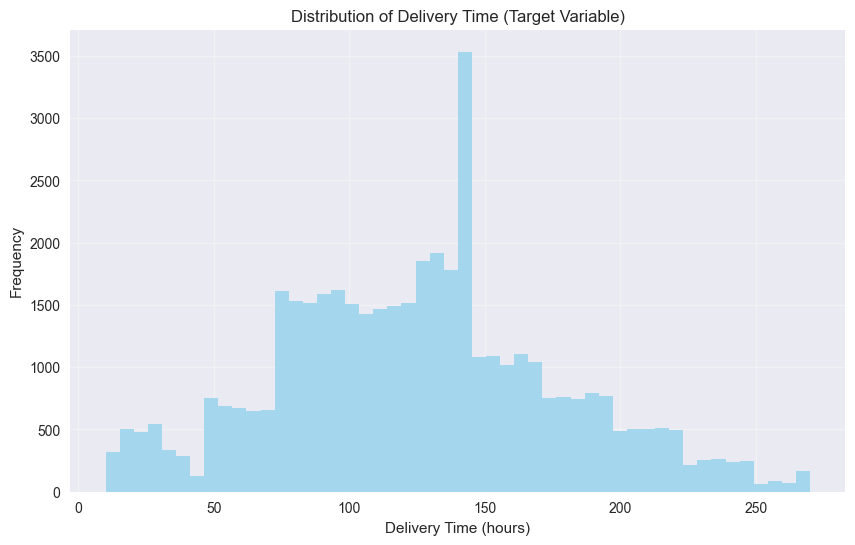

In [26]:
# Check target variable distribution
plt.figure(figsize=(10, 6))
plt.hist(df_final['Delivery_Time'], bins=50, alpha=0.7, color='skyblue')
plt.title('Distribution of Delivery Time (Target Variable)')
plt.xlabel('Delivery Time (hours)')
plt.ylabel('Frequency')
plt.grid(alpha=0.3)
plt.show()

In [27]:
# Separate features and target
X = df_final.drop('Delivery_Time', axis=1)
y = df_final['Delivery_Time']

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")

Features shape: (43648, 22)
Target shape: (43648,)


In [28]:
# Identify categorical and numerical columns
categorical_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

print(f"\nCategorical columns: {categorical_cols}")
print(f"Numerical columns: {numerical_cols}")



Categorical columns: ['distance_category', 'agent_experience', 'agent_age_group', 'Weather', 'Traffic', 'Vehicle', 'Area', 'Category']
Numerical columns: ['Agent_Age', 'Agent_Rating', 'delivery_distance_km', 'agent_performance_score', 'weather_severity', 'traffic_level', 'weather_traffic_impact', 'vehicle_speed_capability', 'area_density', 'vehicle_area_score', 'pickup_delay_hours', 'order_hour']


In [29]:
# Label encode categorical variables for models that don't handle categories well
print(" Encoding categorical variables...")

X_encoded = X.copy()
label_encoders = {}

for col in categorical_cols:
    le = LabelEncoder()
    X_encoded[col] = le.fit_transform(X_encoded[col].astype(str))
    label_encoders[col] = le
    print(f"Encoded {col}: {len(le.classes_)} categories")

print(" Categorical encoding completed!")

 Encoding categorical variables...
Encoded distance_category: 4 categories
Encoded agent_experience: 4 categories
Encoded agent_age_group: 3 categories
Encoded Weather: 6 categories
Encoded Traffic: 4 categories
Encoded Vehicle: 3 categories
Encoded Area: 4 categories
Encoded Category: 16 categories
 Categorical encoding completed!


### Train-Test Split

In [30]:
# Split the data
print(" Splitting data into train and test sets...")

X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, random_state=42
)

print(f"Training set: {X_train.shape}")
print(f"Testing set: {X_test.shape}")
print(f"Target mean - Train: {y_train.mean():.2f}, Test: {y_test.mean():.2f}")


 Splitting data into train and test sets...
Training set: (34918, 22)
Testing set: (8730, 22)
Target mean - Train: 124.70, Test: 125.77


### Creating ML Pipelines

In [33]:
# Create preprocessing and modeling pipelines
print(" Creating ML pipelines...")

# Define preprocessors
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# Combine preprocessors
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ]
)

# Define models with pipelines
pipelines = {
    'Linear Regression': Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', LinearRegression())
    ]),
    
    'Random Forest': Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', RandomForestRegressor(
            n_estimators=100,
            max_depth=10,
            random_state=42,
            n_jobs=-1
        ))
    ]),
    
    'Gradient Boosting': Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', GradientBoostingRegressor(
            n_estimators=100,
            learning_rate=0.1,
            max_depth=5,
            random_state=42
        ))
    ])
}

print(" Pipelines created successfully!")


 Creating ML pipelines...
 Pipelines created successfully!


### Model Training with MLflow Tracking

In [37]:
# Set up MLflow
print(" Setting up MLflow tracking...")
mlflow.set_tracking_uri("../mlruns")
mlflow.set_experiment("Amazon_Delivery_Time_Prediction")

# Dictionary to store results
results = {}

# Train and evaluate each model
for model_name, pipeline in pipelines.items():
    print(f"\n{'='*60}")
    print(f" Training {model_name}...")
    print(f"{'='*60}")
    
    # Start MLflow run
    with mlflow.start_run(run_name=model_name):
        # Train the model
        pipeline.fit(X_train, y_train)
        
        # Make predictions
        y_pred_train = pipeline.predict(X_train)
        y_pred_test = pipeline.predict(X_test)
        
        # Calculate metrics
        metrics = {
            'train_mae': mean_absolute_error(y_train, y_pred_train),
            'test_mae': mean_absolute_error(y_test, y_pred_test),
            'train_rmse': np.sqrt(mean_squared_error(y_train, y_pred_train)),
            'test_rmse': np.sqrt(mean_squared_error(y_test, y_pred_test)),
            'train_r2': r2_score(y_train, y_pred_train),
            'test_r2': r2_score(y_test, y_pred_test),
        }
        
        # Log parameters
        if hasattr(pipeline.named_steps['regressor'], 'get_params'):
            mlflow.log_params(pipeline.named_steps['regressor'].get_params())
        
        # Log metrics
        mlflow.log_metrics({
            'mae': metrics['test_mae'],
            'rmse': metrics['test_rmse'],
            'r2': metrics['test_r2']
        })
        
        # Log model
        mlflow.sklearn.log_model(
            pipeline, 
            model_name.lower().replace(' ', '_')
        )
        
        # Store results
        results[model_name] = {
            'pipeline': pipeline,
            'metrics': metrics,
            'predictions': {
                'train': y_pred_train,
                'test': y_pred_test
            }
        }
        
        # Print results
        print(f"   {model_name} Results:")
        print(f"   Training MAE:  {metrics['train_mae']:.2f} hours")
        print(f"   Testing MAE:   {metrics['test_mae']:.2f} hours")
        print(f"   Training RMSE: {metrics['train_rmse']:.2f} hours")
        print(f"   Testing RMSE:  {metrics['test_rmse']:.2f} hours")
        print(f"   Training R²:   {metrics['train_r2']:.4f}")
        print(f"   Testing R²:    {metrics['test_r2']:.4f}")
        
        # Check for overfitting
        overfit_gap = metrics['train_r2'] - metrics['test_r2']
        if overfit_gap > 0.1:
            print(f"     Potential overfitting (R² gap: {overfit_gap:.3f})")
        else:
            print(f"    Good generalization (R² gap: {overfit_gap:.3f})")

2025/09/30 15:57:09 INFO mlflow.tracking.fluent: Experiment with name 'Amazon_Delivery_Time_Prediction' does not exist. Creating a new experiment.


 Setting up MLflow tracking...

 Training Linear Regression...


2025/09/30 15:57:11 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


   Linear Regression Results:
   Training MAE:  25.26 hours
   Testing MAE:   25.53 hours
   Training RMSE: 32.13 hours
   Testing RMSE:  32.44 hours
   Training R²:   0.6166
   Testing R²:    0.6125
    Good generalization (R² gap: 0.004)

 Training Random Forest...


2025/09/30 15:57:14 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


   Random Forest Results:
   Training MAE:  16.22 hours
   Testing MAE:   16.90 hours
   Training RMSE: 21.02 hours
   Testing RMSE:  21.86 hours
   Training R²:   0.8359
   Testing R²:    0.8241
    Good generalization (R² gap: 0.012)

 Training Gradient Boosting...


2025/09/30 15:57:22 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


   Gradient Boosting Results:
   Training MAE:  17.12 hours
   Testing MAE:   17.59 hours
   Training RMSE: 21.94 hours
   Testing RMSE:  22.55 hours
   Training R²:   0.8213
   Testing R²:    0.8127
    Good generalization (R² gap: 0.009)


### Model Comparision


 MODEL COMPARISON
            Model  Test_MAE  Test_RMSE  Test_R2  Train_R2
    Random Forest 16.901049  21.857680 0.824062  0.835906
Gradient Boosting 17.594513  22.554517 0.812665  0.821271
Linear Regression 25.529086  32.440386 0.612453  0.616615


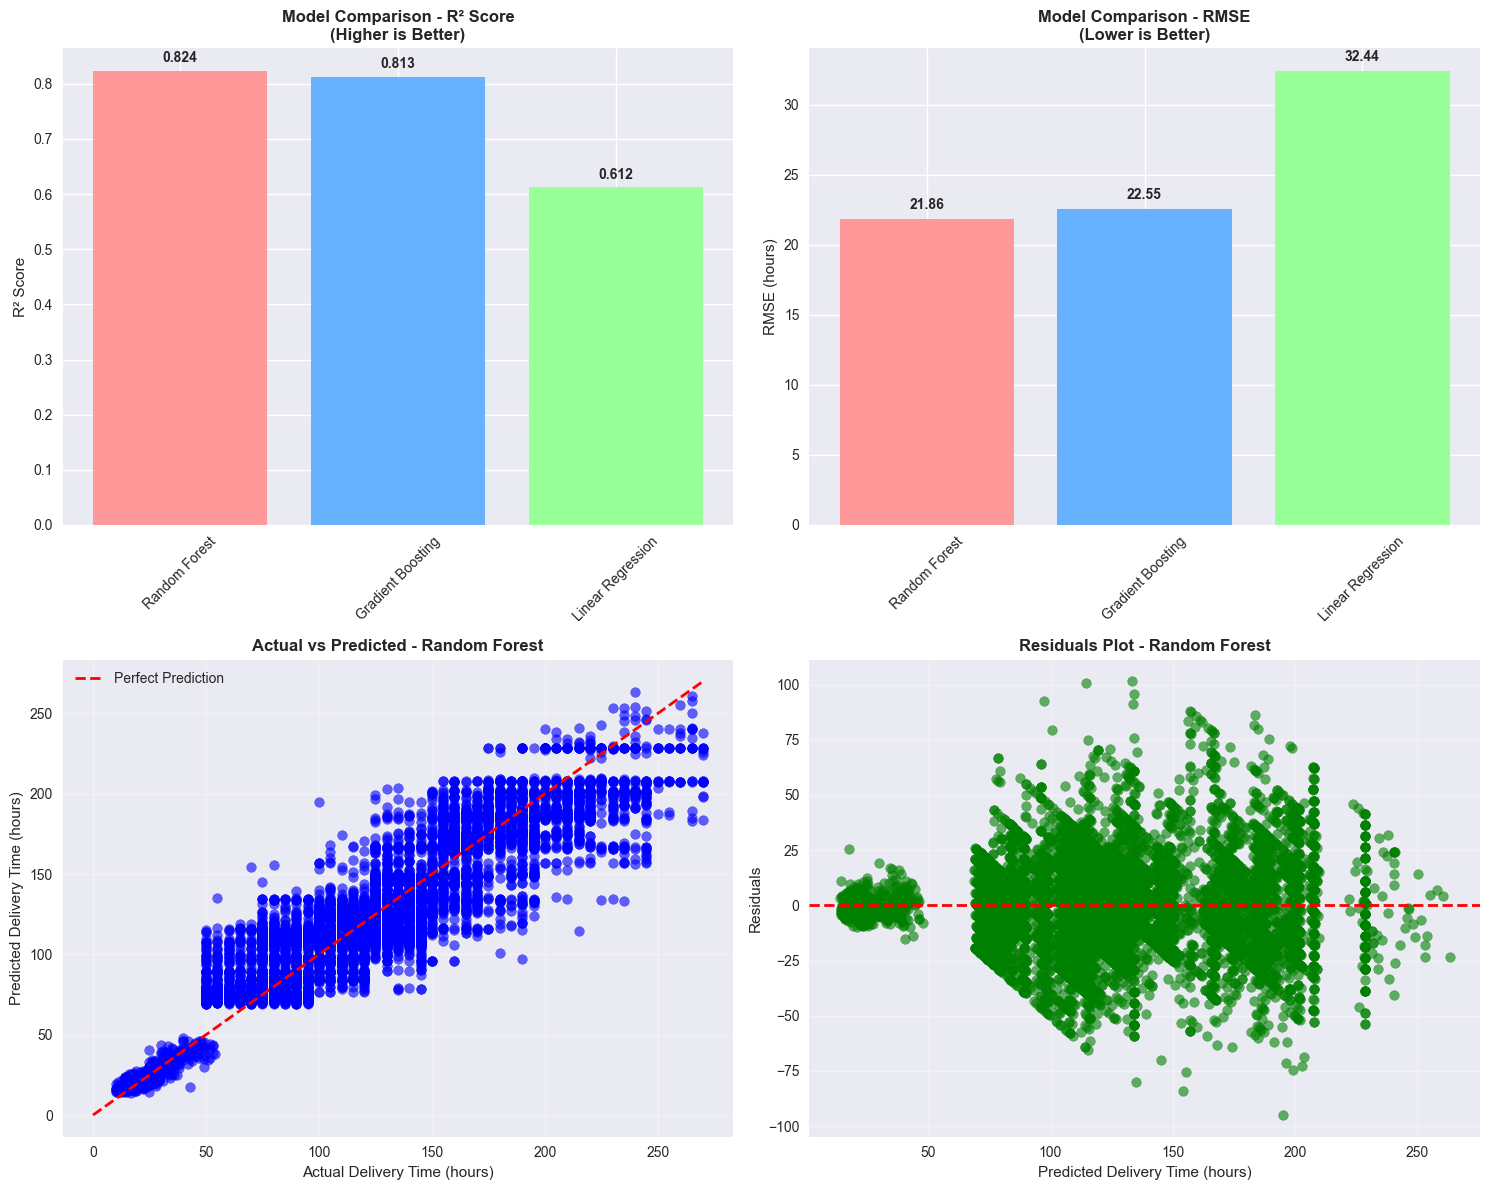

In [35]:
# Create comparison DataFrame
print("\n MODEL COMPARISON")
print("="*50)

comparison_df = pd.DataFrame({
    'Model': list(results.keys()),
    'Test_MAE': [results[model]['metrics']['test_mae'] for model in results.keys()],
    'Test_RMSE': [results[model]['metrics']['test_rmse'] for model in results.keys()],
    'Test_R2': [results[model]['metrics']['test_r2'] for model in results.keys()],
    'Train_R2': [results[model]['metrics']['train_r2'] for model in results.keys()]
}).sort_values('Test_R2', ascending=False)

print(comparison_df.to_string(index=False))


# Visualize model comparison
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# R² Comparison
axes[0,0].bar(comparison_df['Model'], comparison_df['Test_R2'], 
              color=['#FF9999', '#66B2FF', '#99FF99'])
axes[0,0].set_title('Model Comparison - R² Score\n(Higher is Better)', fontweight='bold')
axes[0,0].set_ylabel('R² Score')
axes[0,0].tick_params(axis='x', rotation=45)
for i, v in enumerate(comparison_df['Test_R2']):
    axes[0,0].text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom', fontweight='bold')

# RMSE Comparison
axes[0,1].bar(comparison_df['Model'], comparison_df['Test_RMSE'],
              color=['#FF9999', '#66B2FF', '#99FF99'])
axes[0,1].set_title('Model Comparison - RMSE\n(Lower is Better)', fontweight='bold')
axes[0,1].set_ylabel('RMSE (hours)')
axes[0,1].tick_params(axis='x', rotation=45)
for i, v in enumerate(comparison_df['Test_RMSE']):
    axes[0,1].text(i, v + 0.5, f'{v:.2f}', ha='center', va='bottom', fontweight='bold')

# Actual vs Predicted for best model
best_model_name = comparison_df.iloc[0]['Model']
best_pipeline = results[best_model_name]['pipeline']
y_pred_best = results[best_model_name]['predictions']['test']

axes[1,0].scatter(y_test, y_pred_best, alpha=0.6, color='blue')
max_val = max(y_test.max(), y_pred_best.max())
axes[1,0].plot([0, max_val], [0, max_val], 'r--', lw=2, label='Perfect Prediction')
axes[1,0].set_xlabel('Actual Delivery Time (hours)')
axes[1,0].set_ylabel('Predicted Delivery Time (hours)')
axes[1,0].set_title(f'Actual vs Predicted - {best_model_name}', fontweight='bold')
axes[1,0].legend()
axes[1,0].grid(alpha=0.3)

# Residuals plot
residuals = y_test - y_pred_best
axes[1,1].scatter(y_pred_best, residuals, alpha=0.6, color='green')
axes[1,1].axhline(y=0, color='r', linestyle='--', lw=2)
axes[1,1].set_xlabel('Predicted Delivery Time (hours)')
axes[1,1].set_ylabel('Residuals')
axes[1,1].set_title(f'Residuals Plot - {best_model_name}', fontweight='bold')
axes[1,1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

### Feature Importance Analysis

 Analyzing Feature Importance...


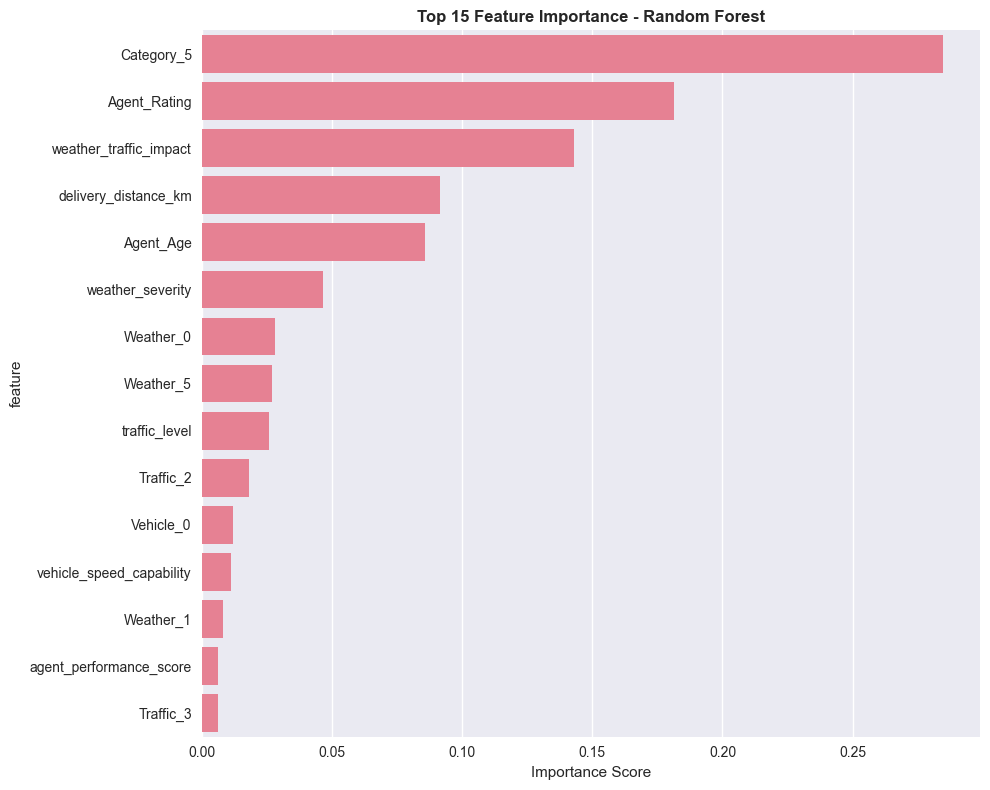

Top 10 Most Important Features:
               feature  importance
            Category_5    0.284636
          Agent_Rating    0.181282
weather_traffic_impact    0.143148
  delivery_distance_km    0.091612
             Agent_Age    0.085730
      weather_severity    0.046499
             Weather_0    0.028182
             Weather_5    0.027227
         traffic_level    0.025832
             Traffic_2    0.018074


In [36]:
# Analyze feature importance for tree-based models
print(" Analyzing Feature Importance...")

# Random Forest feature importance
if 'Random Forest' in results:
    rf_pipeline = results['Random Forest']['pipeline']
    rf_model = rf_pipeline.named_steps['regressor']
    
    # Get feature names after preprocessing
    preprocessor = rf_pipeline.named_steps['preprocessor']
    feature_names = []
    
    # Numerical features
    feature_names.extend(numerical_cols)
    
    # Categorical features (after one-hot encoding)
    categorical_transformer = preprocessor.named_transformers_['cat']
    if hasattr(categorical_transformer, 'named_steps'):
        onehot = categorical_transformer.named_steps['onehot']
        if hasattr(onehot, 'get_feature_names_out'):
            cat_features = onehot.get_feature_names_out(categorical_cols)
            feature_names.extend(cat_features)
    
    # Create feature importance DataFrame
    if hasattr(rf_model, 'feature_importances_'):
        importance_df = pd.DataFrame({
            'feature': feature_names[:len(rf_model.feature_importances_)],
            'importance': rf_model.feature_importances_
        }).sort_values('importance', ascending=False)
        
        plt.figure(figsize=(10, 8))
        sns.barplot(data=importance_df.head(15), y='feature', x='importance')
        plt.title('Top 15 Feature Importance - Random Forest', fontweight='bold')
        plt.xlabel('Importance Score')
        plt.tight_layout()
        plt.show()
        
        print("Top 10 Most Important Features:")
        print(importance_df.head(10).to_string(index=False))


### Saving The Best Model

In [38]:
# Save the best performing model
best_model_name = comparison_df.iloc[0]['Model']
best_pipeline = results[best_model_name]['pipeline']

print(f"   Best Model: {best_model_name}")
print(f"   Test R²: {comparison_df.iloc[0]['Test_R2']:.4f}")
print(f"   Test RMSE: {comparison_df.iloc[0]['Test_RMSE']:.2f} hours")

# Save the model
model_filename = f'../models/best_amazon_delivery_time_model.pkl'
joblib.dump(best_pipeline, model_filename)
print(f" Best model saved as: {model_filename}")

# Also save label encoders for future use
encoders_filename = '../models/label_encoders.pkl'
joblib.dump(label_encoders, encoders_filename)
print(f" Label encoders saved as: {encoders_filename}")


   Best Model: Random Forest
   Test R²: 0.8241
   Test RMSE: 21.86 hours
 Best model saved as: ../models/best_amazon_delivery_time_model.pkl
 Label encoders saved as: ../models/label_encoders.pkl
